In [ ]:
%cd ..

In [1]:
import sys
sys.path.append('.')

In [8]:
from pathlib import Path
import pickle
import json
from functools import partial
from typing import Literal

import numpy as np
import pandas as pd
from datasets import load_dataset, concatenate_datasets
from tqdm.auto import tqdm
import IPython.display
import matplotlib.pyplot as plt
from scipy.special import expit
import librosa
import soundfile as sf

from src.spectrogram_transformer import SEGMENT_SHIFT, AudioSpectrogramTransformer
from src.audioset_utils import pad_or_trim_to_len, display_sample, Features, SEGMENTS_PER_SPAN

In [5]:
labels = json.loads(Path('audioset/labels.json').read_text())

In [3]:
dataset = concatenate_datasets([
    (
        load_dataset(name, split='train')
        .map(lambda s: {'audio': {'path': name + '/' + s['audio']['path']}})
    )
    for name in [
        'datasets/yodas2_ru000_32k',
        'datasets/yodas2_ru001_32k'
    ]
])

Resolving data files:   0%|          | 0/34042 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19298 [00:00<?, ?it/s]

In [4]:
audioset_logits = pickle.loads(Path('tmp/audioset_logits.pkl').read_bytes())
audioset_span_average_probas = pickle.loads(Path('tmp/audioset_span_average_probas.pkl').read_bytes())
audioset_span_max_probas = pickle.loads(Path('tmp/audioset_span_max_probas.pkl').read_bytes())
audioset_span_avgmax_probas = pickle.loads(Path('tmp/audioset_span_avgmax_probas.pkl').read_bytes())

In [ ]:
class_idx = labels.index('Conversation')

matrix = np.vstack([
    pad_or_trim_to_len(x[:, class_idx], 250, value=np.nan)
    for x in audioset_logits
    if len(x) > 24  # 2 min
])
order = np.argsort(np.nanmean(matrix, axis=1))[::-1]
matrix = matrix[order]

plt.figure(figsize=(15, 5))
plt.title(labels[class_idx])
plt.imshow(matrix, aspect='auto', interpolation='nearest', vmin=-5, vmax=0, cmap='brg')
plt.colorbar();

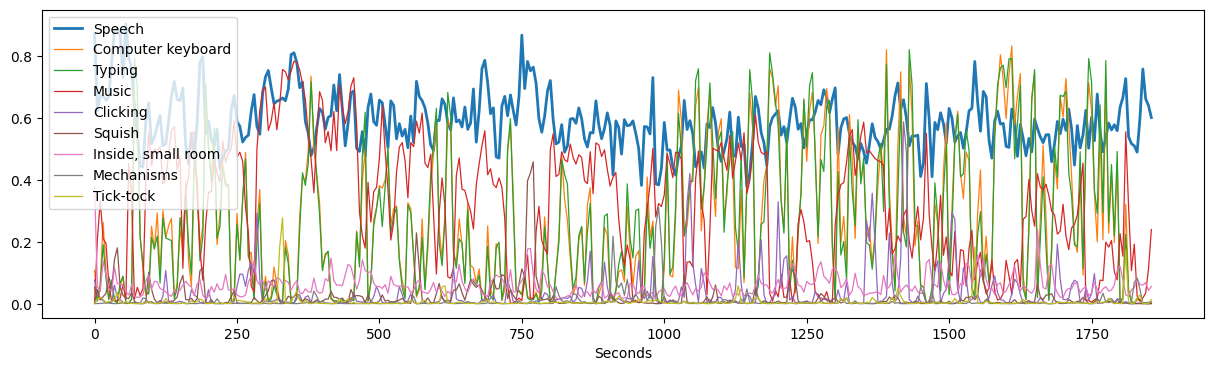

In [7]:
display_sample(
    expit(audioset_logits[2]),
    labels,
    sec_per_tick=5,
    highlight_classes=[labels.index('Speech')]
)

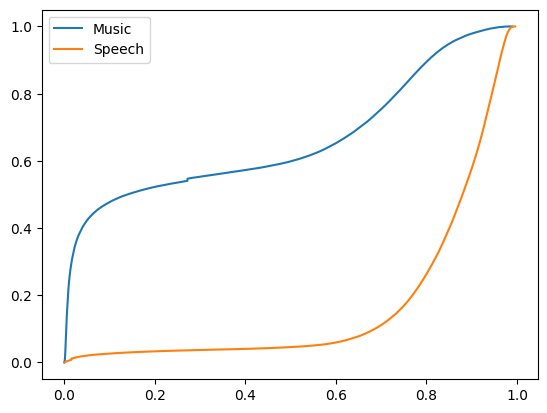

In [9]:
def get_cdf(class_idx: int) -> tuple[np.ndarray, np.ndarray]:
    values = audioset_span_max_probas.data[:, class_idx]
    x, counts = np.unique(values, return_counts=True)
    cusum = np.cumsum(counts)
    y = cusum / cusum[-1]
    return x, y

for class_name in ['Music', 'Speech']:
    plt.plot(*get_cdf(labels.index(class_name)), label=class_name)
plt.legend();

In [10]:
mean_class_scores = audioset_span_average_probas.data.mean(axis=0)
top_classes = mean_class_scores.argsort()[::-1]
[labels[class_idx] for class_idx in top_classes[:10]]

['Speech',
 'Music',
 'Narration, monologue',
 'Male speech, man speaking',
 'Female speech, woman speaking',
 'Speech synthesizer',
 'Inside, small room',
 'Conversation',
 'Clicking',
 'Gasp']

всем привет с вами вадим и мы продолжаем проходить сюжет бриан галактик сурвайвл версии 16 всем приятного просмотра я уже направляюсь на контроль на control station где у нас находится минное поле там у нас стоит тот кораблик который я хочу захватить я произвел некоторые запасы блоков которые мне ну


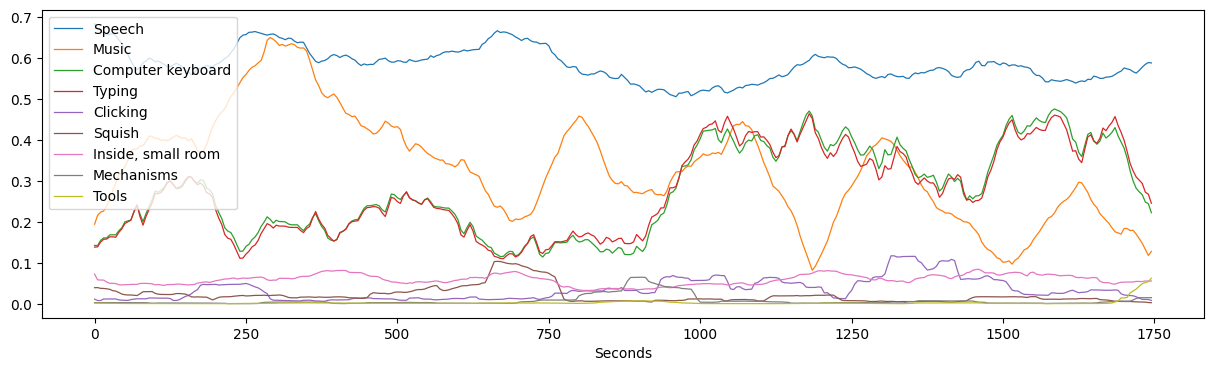

In [ ]:
for sample_idx in [2]:
    print(' '.join(dataset[sample_idx]['utterances']['text'])[:300])
    # display(IPython.display.Audio(dataset[sample_idx]['audio']['path']))
    display_sample(audioset_span_average_probas[sample_idx], labels, sec_per_tick=5)
    plt.show()

In [ ]:
# def sample_segment_for_class(
#     features_to_sample_from: Features,
#     class_idx: int,
#     features_type: Literal['logits', 'probas'],
#     temperature: float = 0.5,
#     seed: int | None = None,
#     exclude_samples: list[int] | None = None,
#     exclude_offsets: list[int] | None = None,
# ) -> tuple[int, int, int]:
#     values_to_sample_from = features_to_sample_from.data[:, class_idx].copy()

#     if features_type == 'probas':
#         logits_to_sample_from = np.log(values_to_sample_from)
#     elif features_type == 'logits':
#         logits_to_sample_from = values_to_sample_from
    
#     if exclude_samples is not None:
#         for sample_idx in exclude_samples:
#             start_offset = features_to_sample_from.sample_indexer[sample_idx]
#             block_length = features_to_sample_from.sample_sizes[sample_idx]
#             logits_to_sample_from[start_offset:start_offset + block_length] = -np.inf
    
#     if exclude_offsets is not None:
#         for offset in exclude_offsets:
#             logits_to_sample_from[offset] = -np.inf
    
#     logits_to_sample_from /= temperature

#     rng = np.random.default_rng(seed=seed)
#     offset = np.argmax(  # Gumbel-max sampling
#         logits_to_sample_from
#         + rng.gumbel(size=len(logits_to_sample_from))
#     )

#     sample_idx = int(features_to_sample_from.sample_ids[offset])
#     step_idx = int(features_to_sample_from.step_ids[offset])
#     return sample_idx, step_idx, offset

# def display_random_segment_for_class(
#     class_idx: int,
#     temperature: float = 0.5,
#     seed: int | None = None,
#     ax: plt.Axes | None = None,
# ):
#     global dataset, labels, ast_logits

#     sample_idx, step_idx, _ = sample_segment_for_class(
#         audioset_span_average_probas, class_idx=class_idx, features_type='probas', temperature=temperature, seed=seed
#     )
#     segment_probas = expit(audioset_logits[sample_idx][step_idx:step_idx + SEGMENTS_PER_SPAN])
#     avg_target_class_proba = segment_probas.mean(axis=0)[class_idx]
#     max_target_class_proba = segment_probas.max(axis=0)[class_idx]
#     max_target_class_timestamp = np.argmax(segment_probas[:, class_idx]) * SEGMENT_SHIFT

#     # displaying info and transcription
#     print(
#         f'sample {sample_idx} | segment {step_idx}'
#         + f' | target class proba avg {avg_target_class_proba:.5f}'
#         f', max {max_target_class_proba:.5f} ({max_target_class_timestamp:.1f} sec)'
#         + '\ntext for the full audio: '
#         + ' '.join(dataset[sample_idx]['utterances']['text'])[:300]
#     )
    
#     # displaying audio
#     waveform, rate = librosa.load(audio_path := dataset[sample_idx]['audio']['path'])
#     start_time = 5 * step_idx
#     end_time = start_time + 120
#     segment = waveform[round(rate * start_time):round(rate * end_time)]
#     print(audio_path)
#     display(IPython.display.Audio(segment, rate=rate))

#     display_sample(segment_probas, labels, sec_per_tick=5, highlight_classes=[class_idx], ax=ax)

# display_random_segment_for_class(labels.index('Battle cry'), seed=1)

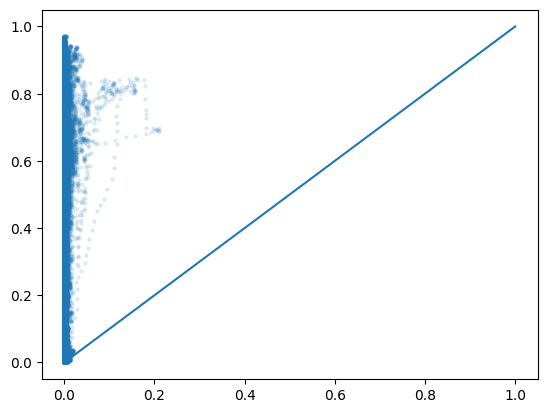

In [17]:
cls = audioset_span_average_probas.data[:, labels.index('Shout')]
subcls = audioset_span_average_probas.data[:, labels.index('Music')]

plt.scatter(cls, subcls, s=5, alpha=0.1)
plt.plot([0, 1], [0, 1]);

In [ ]:
class_idx = labels.index('Laughter')
logits = audioset_logits.data[:, class_idx]
not_music = expit(audioset_logits.data[:, labels.index('Music')]) < 0.3
offsets_sorted = np.argsort(logits)[::-1]
indices_in_offsets_sorted = np.where(not_music[offsets_sorted])[0][:50]
for idx_in_offsets_sorted in indices_in_offsets_sorted:
    offset = offsets_sorted[idx_in_offsets_sorted]
    sample_idx = audioset_logits.sample_ids[offset]
    step_idx = audioset_logits.step_ids[offset]
    
    audio_path = Path(dataset[int(sample_idx)]['audio']['path'])
    audio, sr = librosa.load(audio_path)
    start_time, end_time = audioset_logits.get_step_timings(step_idx)
    audio = audio[round(start_time * sr):round(end_time * sr)]
    
    probas = expit(audioset_logits[sample_idx][step_idx, :])
    p_music = probas[labels.index('Music')]
    p_class = probas[class_idx]

    output_path = Path(
        f'tmp/class_short_samples/{labels[class_idx]}/'
        f'({idx_in_offsets_sorted:04d}) id {sample_idx} step {step_idx} offset {offset}'
        f', p={p_class:.2f} p(music)={p_music:.2f} {audio_path.name}'
    )
    print(output_path)
    output_path.parent.mkdir(exist_ok=True, parents=True)
    sf.write(output_path, audio, samplerate=sr)

In [ ]:
# import torch
# from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
# from datasets import load_dataset

# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# model_id = "openai/whisper-large-v3"

# model = AutoModelForSpeechSeq2Seq.from_pretrained(
#     model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
# )
# model.to(device)

# processor = AutoProcessor.from_pretrained(model_id)

# pipe = pipeline(
#     "automatic-speech-recognition",
#     model=model,
#     tokenizer=processor.tokenizer,
#     feature_extractor=processor.feature_extractor,
#     torch_dtype=torch_dtype,
#     device=device,
#     generate_kwargs={
#         'language': '<|ru|>',
#         'task': 'transcribe',
#         'forced_decoder_ids': None
#     }
# )

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# for path in sorted(Path('tmp/class_short_samples/Laughter').glob('*.mp3')):
#     text = pipe(str(path))['text']
#     print(f'{path}\n\t{text}')

Device set to use cuda:0
